In [1]:
!gdown 1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h

Downloading...
From: https://drive.google.com/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h
To: /content/title_brand.csv
100% 97.3M/97.3M [00:02<00:00, 42.7MB/s]


In [2]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW

Downloading...
From: https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
To: /content/train_data.csv
100% 635M/635M [00:11<00:00, 53.6MB/s]


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train_data.csv').drop(['reviewTime', 'unixReviewTime', 'style'], axis=1)
extra = pd.read_csv('title_brand.csv')

In [3]:
data['feeling'] = data['overall'].apply(lambda x: 1 if x in [4, 5] else -1 if x in [1, 2] else 0)
data

,overall,vote,verified,reviewerID,asin,reviewerName,reviewText,summary,feeling
0,2,NaN,False,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,-1
1,5,NaN,True,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1
2,4,NaN,True,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1
3,5,NaN,True,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1
4,5,NaN,True,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1
...,...,...,...,...,...,...,...,...,...
838939,5,NaN,True,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.,1
838940,1,NaN,True,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,-1
838941,3,NaN,True,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,0
838942,5,2.0,True,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,1


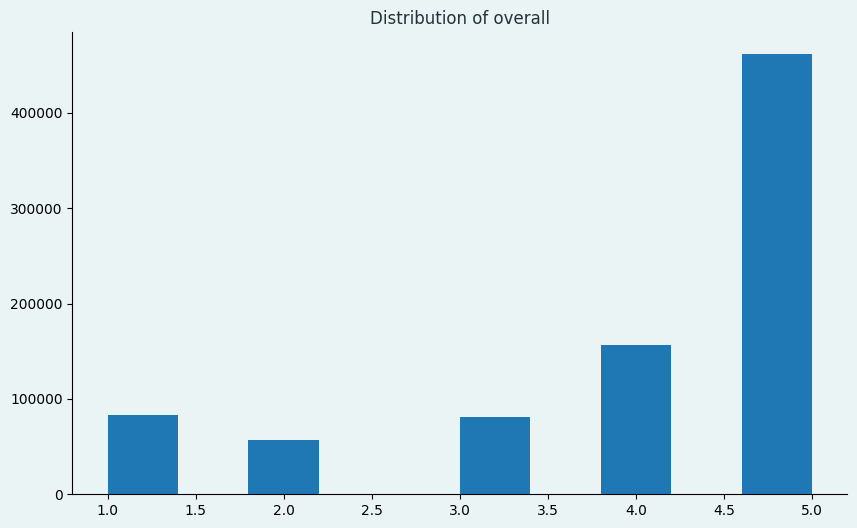

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data['overall'])
ax.set_title(
    "Distribution of overall", color="#22333b", fontsize=12
)
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [5]:
nlp = spacy.load("en_core_web_sm")
def process_text(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]
    return tokens

In [7]:
word_freq_bad = defaultdict(int)

df_bad = data[data['feeling'] == -1]
batch_size = 100
num_batches = len(df_bad) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_bad['reviewText'][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(text) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_bad[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_bad['reviewText'][num_batches * batch_size:]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_bad[token] += 1

freq_bad = pd.DataFrame(list(word_freq_bad.items()), columns=['Word', 'Frequency'])
freq_bad.to_csv('freq_bad.csv')

100%|██████████| 1397/1397 [53:12<00:00,  2.28s/it]


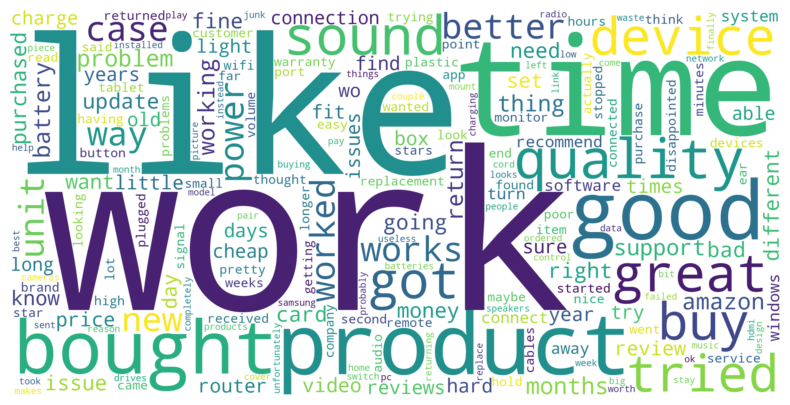

In [10]:
mask = np.array(Image.open("min.jpg"))
words_to_remove = ["use", "phone", "cable", "camera", "usb", "tv", "laptop", "speaker", "screen", "charger", "mouse", "plug", "ipad", "adapter", "bluetooth", "computer", "drive", "keyboard", "wireless", "headphones"]
for word in words_to_remove:
    if word in word_freq_bad:
        del word_freq_bad[word]
wordcloud_bad_shape = WordCloud(width=2400, height=2400, background_color='white', mask=mask, colormap='viridis').generate_from_frequencies(word_freq_bad)
wordcloud_bad = WordCloud(width=2400, height=1200, background_color='white', colormap='viridis').generate_from_frequencies(word_freq_bad)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud_bad_shape.to_file("min_shape_output1.png")
wordcloud_bad.to_file("min_output1.png")

In [12]:
word_freq_soso = defaultdict(int)

df_soso = data[data['feeling'] == 0]
batch_size = 100
num_batches = len(df_soso) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_soso['reviewText'][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(text) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_soso[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_soso['reviewText'][num_batches * batch_size:]
remaining_tokens = [process_text(text) for text in remaining_texts]
for tokens in remaining_tokens:
    for token in tokens:
        word_freq_soso[token] += 1

freq_soso = pd.DataFrame(list(word_freq_soso.items()), columns=['Word', 'Frequency'])
freq_soso.to_csv('freq_soso.csv')

100%|██████████| 812/812 [33:18<00:00,  2.46s/it]


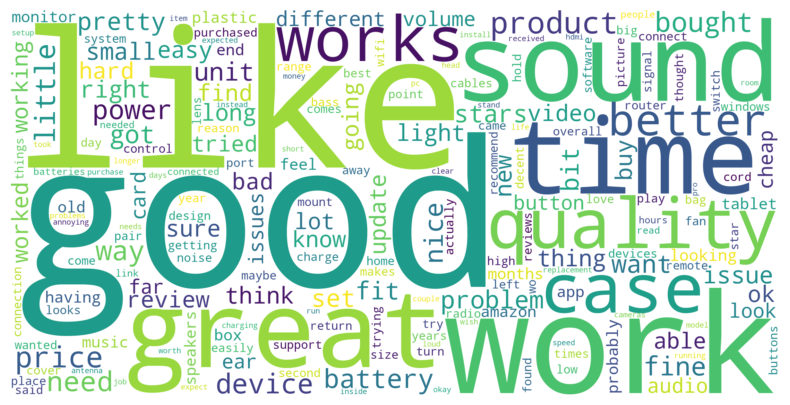

In [13]:
mask = np.array(Image.open("equal.jpg"))
words_to_remove = ["use", "phone", "cable", "camera", "usb", "tv", "laptop", "speaker", "screen", "charger", "mouse", "plug", "ipad", "adapter", "bluetooth", "computer", "drive", "keyboard", "wireless", "headphones"]
for word in words_to_remove:
    if word in word_freq_soso:
        del word_freq_soso[word]
wordcloud_soso_shape = WordCloud(width=2400, height=2400, background_color='white', mask=mask, colormap='viridis').generate_from_frequencies(word_freq_soso)
wordcloud_soso = WordCloud(width=2400, height=1200, background_color='white', colormap='viridis').generate_from_frequencies(word_freq_soso)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_soso, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud_soso_shape.to_file("equal_shape_output1.png")
wordcloud_soso.to_file("equal_output1.png")

In [14]:
word_freq_good = defaultdict(int)

df_good = data[data['feeling'] == 1]
batch_size = 100
num_batches = len(df_good) // batch_size

for i in tqdm(range(num_batches)):
    batch_texts = df_good['reviewText'][i * batch_size : (i + 1) * batch_size]
    batch_tokens = [process_text(text) for text in batch_texts]

    for tokens in batch_tokens:
        for token in tokens:
            word_freq_good[token] += 1

# Process the remaining texts (if any) that didn't fit into a full batch
remaining_texts = df_good['reviewText'][num_batches * batch_size:]
remaining_tokens = [process_text(text) for text in remaining_texts]

for tokens in remaining_tokens:
    for token in tokens:
        word_freq_good[token] += 1


freq_good = pd.DataFrame(list(word_freq_good.items()), columns=['Word', 'Frequency'])
freq_good.to_csv('freq_good.csv')

100%|██████████| 6179/6179 [3:46:11<00:00,  2.20s/it]  


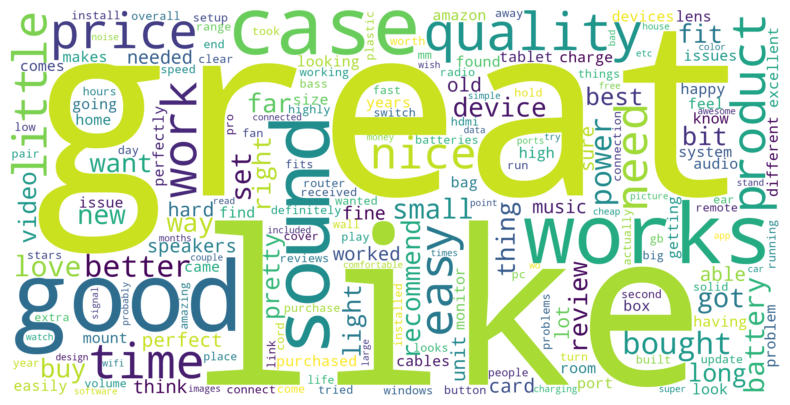

In [15]:
mask = np.array(Image.open("plus.jpg"))
words_to_remove = ["use", "phone", "cable", "camera", "usb", "tv", "laptop", "speaker", "screen", "charger", "mouse", "plug", "ipad", "adapter", "bluetooth", "computer", "drive", "keyboard", "wireless", "headphones"]
for word in words_to_remove:
    if word in word_freq_good:
        del word_freq_good[word]
wordcloud_good_shape = WordCloud(width=2400, height=2400, background_color='white', mask=mask, colormap='viridis').generate_from_frequencies(word_freq_good)
wordcloud_good = WordCloud(width=2400, height=1200, background_color='white', colormap='viridis').generate_from_frequencies(word_freq_good)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud_good.to_file("plus1_output.png")
wordcloud_good_shape.to_file("plus1_shape_output.png")

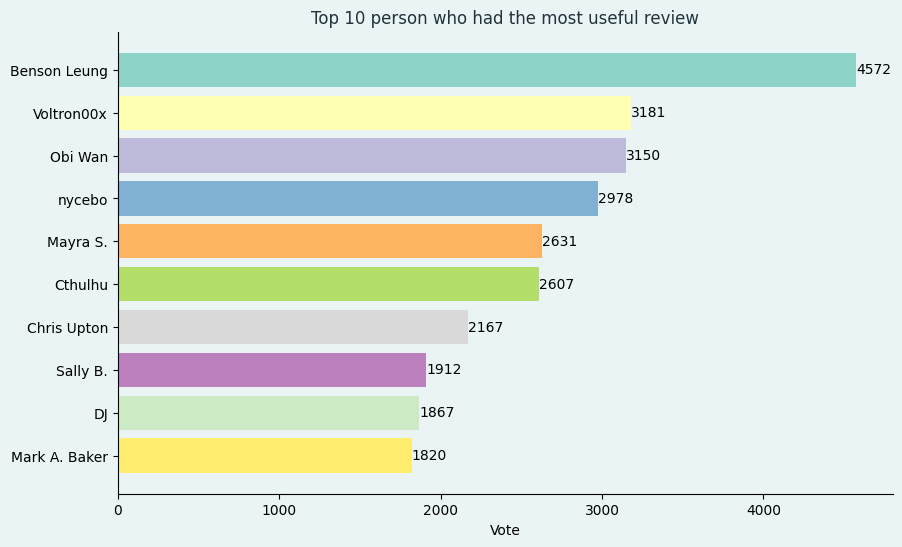

In [16]:
df = data.dropna(subset=['vote'])
df['vote'] = df['vote'].apply(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x).astype(int)
vote_sum = df.groupby('reviewerID')['vote'].sum()
vote_sum = vote_sum.sort_values( ascending=False).head(10)
result = pd.merge(vote_sum, df[['reviewerID', 'reviewerName']].drop_duplicates(), on='reviewerID', how='left')
result['reviewerName'].unique()


fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(result)))

bars = ax.barh(result['reviewerName'], result['vote'], color=colors)
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', ha='left', va='center')

ax.set_title('Top 10 person who had the most useful review', color="#22333b", fontsize=12)
ax.set_xlabel('Vote')
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()